# Trans-dimensional modeling of power law data

### We construct time-domain data obeying a power law. The data is modeled using a collection of Fourier coefficients. The number of frequency bins is allowed to vary trans-dimensionally. Generally, the higher the white noise level, the fewer frequency bins preferred in the model.

# Simulate data

In [1]:
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from corner import corner

from BayesFT import functions as f
from BayesFT import hierarch_trans_model as htm
from BayesFT.RJMCMC import RJMCMC
from BayesFT import jumps

In [2]:
# time series over which data is collected
t0 = 0.
t1 = 1.
Tspan = t1 - t0
Nt = 100
t = jnp.linspace(t0, t1, Nt)

# frequency bins injected into data (neglecting zero frequency)
Nf_inj = t.shape[0] // 2
Na_inj = 2 * Nf_inj
f_inj = jnp.arange(1, Nf_inj + 1) / Tspan
logf_inj = jnp.log(f_inj)
df_inj = f_inj[1] - f_inj[0]

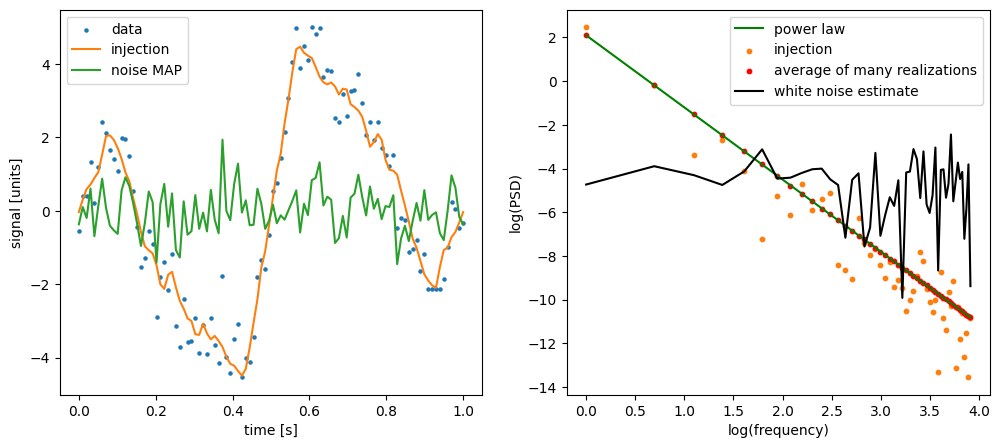

In [3]:
# injected hyper-parameters
log_amp_inj = 1.4
gamma_inj = 3.3
hypers_inj = jnp.array([log_amp_inj, gamma_inj])
diag_cov_inj = f.fast_diag_power_law_cov(log_amp_inj, gamma_inj, f_inj)

# use Cholesky decomposition to make correlated Fourier coefficients
a_seed = jr.PRNGKey(77)  # seed for injected Fourier coefficients
a_inj = np.sqrt(diag_cov_inj) * jr.normal(a_seed, shape=(Na_inj,))

# check accuracy of injection by averaging over many realizations
many_a = np.sqrt(diag_cov_inj) * jr.normal(a_seed, shape=(10_000, Na_inj))

# simulate power law signal in time-domain
F_inj = f.fast_Fourier_design(t, f_inj)
signal_inj = F_inj @ a_inj

# add zero-mean Gaussian noise
log_sigma_inj = -0.5
sigma_inj = np.exp(log_sigma_inj)
noise_seed = jr.PRNGKey(34)
noise = jr.normal(noise_seed, shape=(Nt,)) * sigma_inj
noise_a_ML = jnp.linalg.pinv(F_inj) @ noise

# make and plot data
data = signal_inj + noise
data -= jnp.mean(data)

# time-domain
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(t, data, color='C0', s=5, label='data')
plt.plot(t, signal_inj, color='C1', label='injection')
plt.plot(t, F_inj @ noise_a_ML, color='C2', label='noise MAP')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend()

# frequency-domain
plt.subplot(1, 2, 2)
plt.plot(logf_inj, np.log(diag_cov_inj[::2] + diag_cov_inj[1::2]), color='green', label='power law')
plt.scatter(logf_inj, np.log(a_inj[::2]**2. + a_inj[1::2]**2.), color='C1', s=10, label='injection')
plt.scatter(logf_inj, np.log(np.mean(many_a[:,::2]**2. + many_a[:,1::2]**2., axis=0)), color='red', s=10, 
            label='average of many realizations')
plt.plot(logf_inj, np.log(noise_a_ML[::2]**2. + noise_a_ML[1::2]**2.), color='k', label='white noise estimate')
plt.xlabel('log(frequency)')
plt.ylabel('log(PSD)')
plt.legend()
plt.show()

# Trans-dimensional hierarchical model

In [4]:
model = htm.Hierarch_trans_model(t, data, hypers_inj, max_Nf=15)

# MCMC

In [5]:
# jump proposals
Jump_obj = jumps.Trans_dim_jumps(model.models_x_ML, model.fast_lnlike, model.fast_lnpost, model.num_models - 1,
                                 model.a_min, model.a_max)

jump_proposals = [[Jump_obj.hierarch_Fisher_jump, 40],
                  [Jump_obj.hierarch_uniform_trans_dim_jump, 20],
                  [Jump_obj.hierarch_ML_trans_dim_jump, 5]]

In [6]:
# do parallel tempering MCMC
num_samples = int(2e5)
num_chains = 15
chains = RJMCMC(num_samples=num_samples,
                num_chains=num_chains,
                x0=model.models_x_ML[0],
                lnpost_func=model.fast_lnpost,
                jump_proposals=jump_proposals,
                PT_weight=20)

/Users/aidengundersen/Desktop/BayesFT/BayesFT/jumps.py:213: RuntimeWarning: overflow encountered in exp
  acc_prob = np.exp(log_acc_prob)


/Users/aidengundersen/Desktop/BayesFT/BayesFT/jumps.py:213: RuntimeWarning: overflow encountered in exp
  acc_prob = np.exp(log_acc_prob)


/Users/aidengundersen/Desktop/BayesFT/BayesFT/jumps.py:213: RuntimeWarning: overflow encountered in exp
  acc_prob = np.exp(log_acc_prob)
/Users/aidengundersen/Desktop/BayesFT/BayesFT/jumps.py:213: RuntimeWarning: overflow encountered in exp
  acc_prob = np.exp(log_acc_prob)


/Users/aidengundersen/Desktop/BayesFT/BayesFT/jumps.py:213: RuntimeWarning: overflow encountered in exp
  acc_prob = np.exp(log_acc_prob)


Jump acceptance rates
hierarch_Fisher_jump: [0.73300334 0.73200914 0.73047553 0.7282227  0.72277573 0.69715911
 0.6846258  0.67500106 0.66796759 0.67004061 0.66731184 0.65973897
 0.64951136 0.62347168 0.57957863]
hierarch_uniform_trans_dim_jump: [0.00046949 0.00044815 0.00040547 0.00049083 0.00040547 0.00027743
 0.00021341 0.00034145 0.00034145 0.00049083 0.00070424 0.00142982
 0.00256087 0.00670095 0.01412749]
hierarch_ML_trans_dim_jump: [0.00127834 0.00187489 0.000767   0.00093745 0.00068178 0.00059656
 0.00042611 0.00034089 0.00017044 0.00017044 0.00017044 0.00051133
 0.00051133 0.00059656 0.001534  ]
PT swap: [0.74486747 0.76558965 0.76475735 0.65619531 0.42709889 0.62386359
 0.78170216 0.81896368 0.81465278 0.80425968 0.78772035 0.74042853
 0.67736566 0.66643903        nan]


/Users/aidengundersen/Desktop/BayesFT/BayesFT/RJMCMC.py:137: RuntimeWarning: invalid value encountered in divide
  acceptance_rates = accept_counts / (accept_counts + reject_counts)


# Post-processing

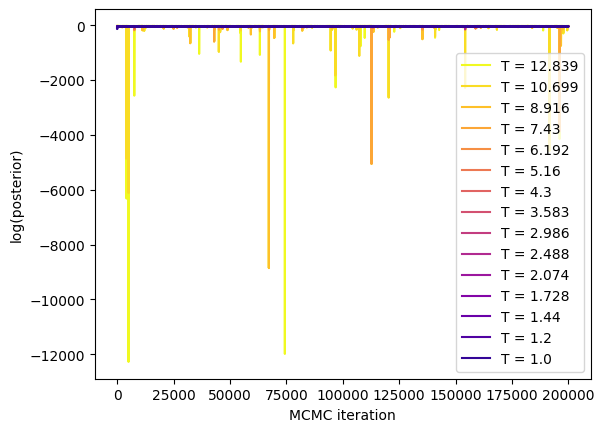

In [7]:
# plot posterior values of chains (with temperature scaling)
temp_ladder = np.array([chain.temperature for chain in chains])
lnposts = np.array([chain.lnposts for chain in chains])
chain_colors = list(reversed([plt.cm.plasma(i / num_chains) for i in range(1, num_chains + 1)]))
for j, (temp, color) in enumerate(zip(temp_ladder[::-1], chain_colors)):
    plt.plot(lnposts[::-1][j], color=color, label=f'T = {round(temp, 3)}')
plt.xlabel('MCMC iteration')
plt.ylabel('log(posterior)')
plt.legend(loc='lower right')
plt.show()

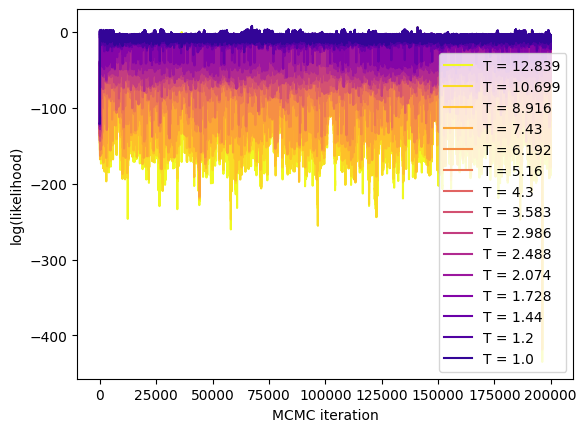

In [8]:
# plot likelihood values (without temperature scaling)
lnlikes = np.array([[model.fast_lnlike(samp) for samp in chain.samples]
                    for chain in chains])
for j, (temp, color) in enumerate(zip(temp_ladder[::-1], chain_colors)):
    plt.plot(lnlikes[::-1][j], color=color, label=f'T = {round(temp, 3)}')
plt.xlabel('MCMC iteration')
plt.ylabel('log(likelihood)')
plt.legend(loc='lower right')
plt.show()

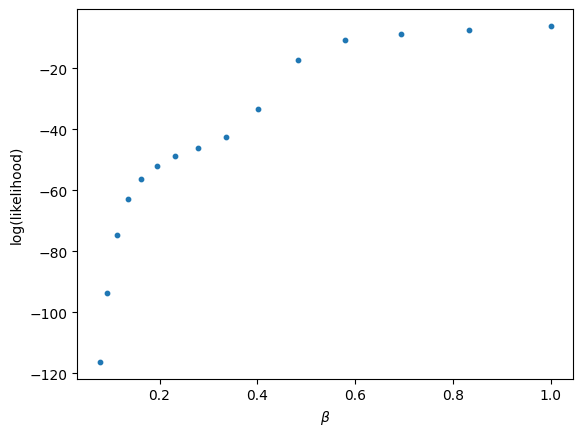

In [9]:
# plot average likelihood as function of beta = 1 / T
betas = 1. / temp_ladder
avg_lnlikes = np.mean(lnlikes, axis=1)
plt.scatter(betas, avg_lnlikes, s=10)
plt.xlabel(r'$\beta$')
plt.ylabel('log(likelihood)')
plt.show()

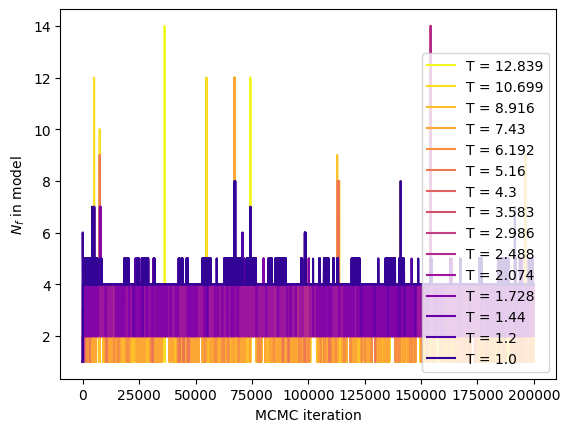

In [10]:
# model trace plot
model_Nfs = np.array([[(samp.shape[0] - 3) // 2 for samp in chain.samples]
                      for chain in chains])
for j, (temp, color) in enumerate(zip(temp_ladder[::-1], chain_colors)):
    plt.plot(model_Nfs[::-1][j], color=color, label=f'T = {round(temp, 3)}')
plt.xlabel('MCMC iteration')
plt.ylabel(r'$N_f$ in model')
plt.legend(loc='lower right')
plt.show()

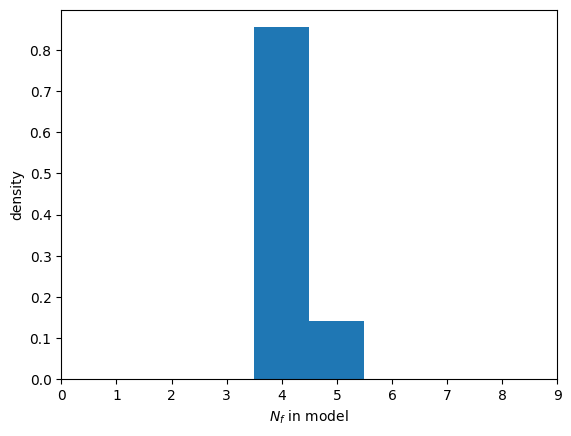

In [11]:
# model histogram
chain_ndx = 0
burnin = num_samples // 5
max_Nf = np.max(model_Nfs[chain_ndx])
bins = np.arange(-0.5, max_Nf + 1.5, 1)
plt.hist(model_Nfs[chain_ndx], density=True, bins=bins)
plt.xlim(0, max_Nf + 1)
plt.xlabel(r'$N_f$ in model')
plt.ylabel('density')
plt.show()

In [12]:
# samples with NaNs in empty dimensions
samples = np.array([np.concatenate((np.array(samp),
                                    np.full(2 * max_Nf + 3 - len(samp), np.nan))) 
                                    for samp in chains[0].samples])

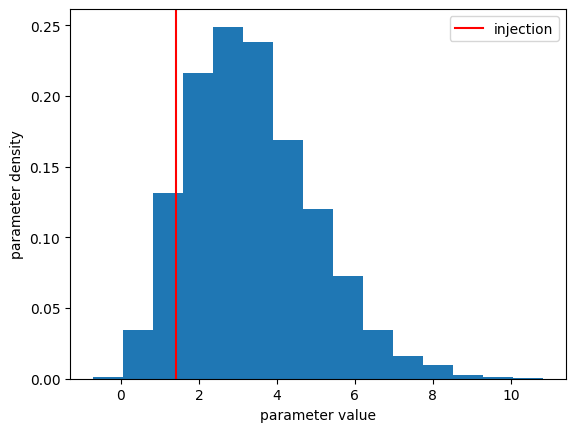

In [13]:
# posterior marginalized over models
param_index = 0
plt.hist(samples[burnin:, param_index], density=True, bins=15)
plt.axvline(model.models_x_ML[-1][param_index], color='red', label='injection')
plt.xlabel('parameter value')
plt.ylabel('parameter density')
plt.legend()
plt.show()

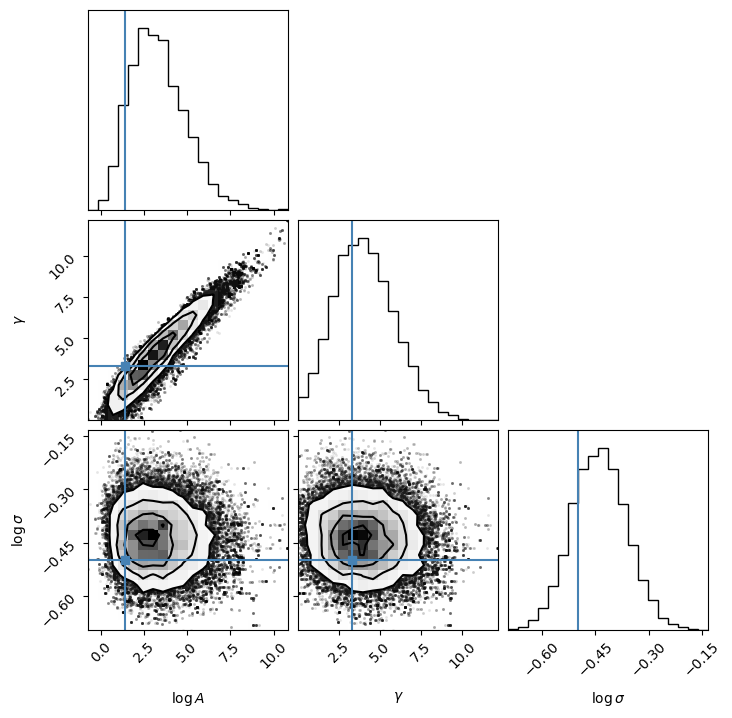

In [14]:
# corner plot for hyper-parameters
fig = corner(samples[burnin:, :3],
             truths=np.array([log_amp_inj, gamma_inj, log_sigma_inj]),
             labels=[r'$\log A$', r'$\gamma$', r'$\log\sigma$'])

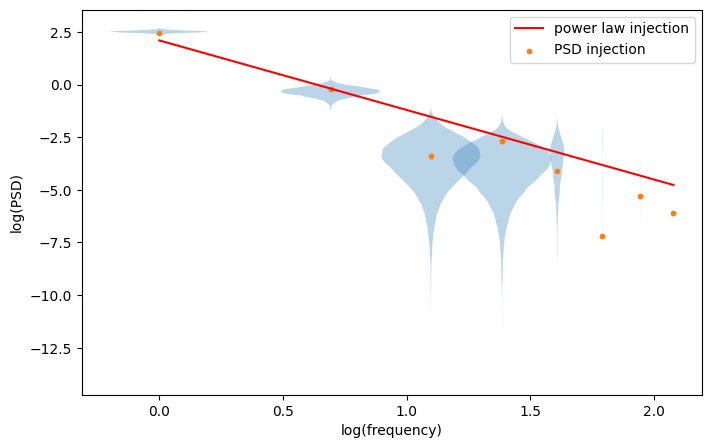

In [15]:
# violin plot
logPSDs = [[] for _ in range(max_Nf)]

for samp in chains[chain_ndx].samples:
    a_samples = np.array(samp[3:])
    logPSD_samples = np.log(a_samples[::2]**2. + a_samples[1::2]**2.)
    for i, logPSD in enumerate(logPSD_samples):
        logPSDs[i].append(logPSD)

max_count = len(logPSDs[0])

fig, ax = plt.subplots(figsize=(8, 5))
for i in range(max_Nf):
    logPSD_arr = np.array(logPSDs[i])
    vp = ax.violinplot(logPSD_arr,
                       positions=[np.log(model.models_f[-1])[i]],
                       showextrema=False,
                       widths=0.4 * logPSD_arr.shape[0] / max_count)
    for body in vp['bodies']:
        body.set_facecolor('C0')

# injected power law
plt.plot(logf_inj[:max_Nf], np.log(diag_cov_inj[::2] + diag_cov_inj[1::2])[:max_Nf], color='red',
         label='power law injection')

# injected PSD
plt.scatter(logf_inj[:max_Nf], np.log(a_inj[::2]**2. + a_inj[1::2]**2.)[:max_Nf], color='C1', s=10,
            label='PSD injection')

plt.legend(loc='upper right')
plt.xlabel('log(frequency)')
plt.ylabel('log(PSD)')
plt.show()

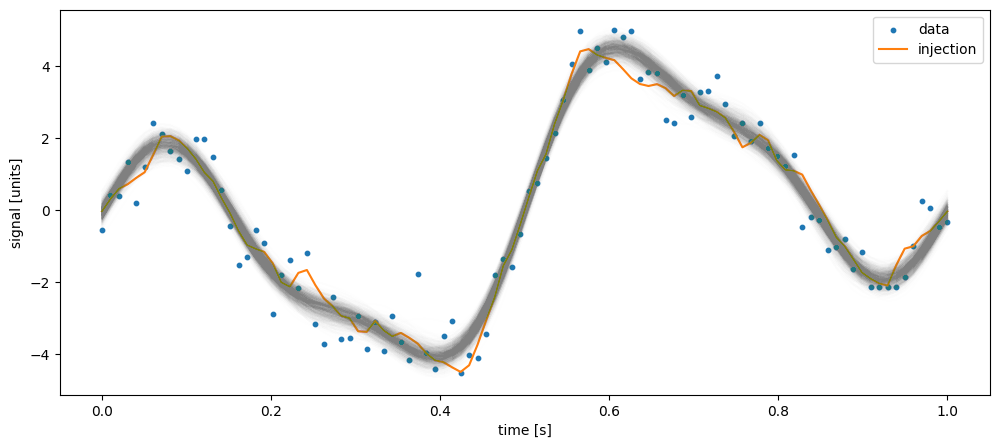

In [16]:
# Bayesogram

# fair draws from posterior
num_draws = 1000
draw_ndxs = np.random.choice(np.arange(burnin, num_samples), num_draws)

plt.figure(figsize=(12, 5))
plt.scatter(t, data, color='C0', s=10, label='data')
plt.plot(t, signal_inj, color='C1', label='injection')
for ndx in draw_ndxs:
    a = chains[0].samples[ndx][3:]
    model_ndx = a.shape[0] // 2 - 1
    plt.plot(t, model.models_F[model_ndx] @ a, color='grey', alpha=5./num_draws)
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend(loc='upper right')
plt.show()